## TUF Region Clustering

- Region: [1000000-20000000]
- Window size: 100
- Sam configuration

```
"sam_read_config":{
    "max_depth":1000,
    "ignore_orphans":false,
    "truncate":true,
    "quality_threshold":20,
    "add_indels":true
  },
```

```sklearn``` GMM: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

```sklearn``` GMM: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.fit

In [1]:
import sys
sys.path.append("../")

In [2]:
from itertools import cycle, islice

In [3]:
from sklearn import mixture
from sklearn import metrics
from sklearn.cluster import KMeans

In [4]:
import numpy as np
from scipy.stats import kde
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [5]:
sns.set(color_codes=True)

In [6]:
def load_data_file(filename):

    with open(filename) as file:
        context = file.read()
        size = len(context)
        arraystr= context[1:size-1]
        arraystr = arraystr.split(',')
        region_means = [float(item) for item in arraystr]
        return region_means

In [7]:
wga_mean_file = "/home/a/ag568/wga_windows_mean_0_GMM.txt"
no_wga_mean_file = "/home/a/ag568/no_wga_windows_mean_0_GMM.txt"
gc_file = "/home/a/ag568/windows_gc_0_GMM.txt"

In [8]:
wga_mu = load_data_file(filename=wga_mean_file)
no_wga_mu = load_data_file(filename=no_wga_mean_file)
gc = load_data_file(filename=gc_file)

In [9]:
assert len(wga_mu) == len(no_wga_mu)
assert len(gc) == len(wga_mu)

In [10]:
print("Size of WGA sample {0}".format(len(wga_mu)))
print("WGA max: {0}".format(max(wga_mu)))
print("WGA min: {0}".format(min(wga_mu)))
print("WGA mean: {0}".format(np.mean(wga_mu)))
print("WGA var: {0}".format(np.var(wga_mu)))

Size of WGA sample 185329
WGA max: 52.13
WGA min: 0.0
WGA mean: 18.00699696215919
WGA var: 100.56252905243802


In [11]:
#sns.distplot(wga_mu, bins=35, kde=False, rug=True)
#plt.xlabel("WGA means")
#plt.show()

In [12]:
print("NO-WGA size {0}".format(len(no_wga_mu)))
print("NO-WGA max: {0}".format(max(no_wga_mu)))
print("NO-WGA min: {0}".format(min(no_wga_mu)))
print("NO-WGA mean: {0}".format(np.mean(no_wga_mu)))
print("NO-WGA var: {0}".format(np.var(no_wga_mu)))

NO-WGA size 185329
NO-WGA max: 35.17
NO-WGA min: 0.0
NO-WGA mean: 16.24269504502803
NO-WGA var: 21.10931204078077


In [13]:
#sns.distplot(no_wga_mu, bins=35, kde=False, rug=True)
#plt.xlabel("NO-WGA means")
#plt.show()

In [14]:
X = np.stack((no_wga_mu, wga_mu), axis=0)
cov = np.cov(X)
print("Covariance matrix: \n", cov)

v, w = linalg.eigh(cov)
print(" Eigenvalues: \n", v)
print(" Eigenvectors: \n", w)

Covariance matrix: 
 [[ 21.10942594  11.99723456]
 [ 11.99723456 100.56307167]]
 Eigenvalues: 
 [ 19.33740434 102.33509327]
 Eigenvectors: 
 [[-0.98926728  0.14611726]
 [ 0.14611726  0.98926728]]


In [15]:
pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
print("Pearson correlation: ", pearson)

Pearson correlation:  0.26038962327560194


In [16]:
ratio = []
for no_wga, wga  in zip(no_wga_mu, wga_mu):
    ratio.append((wga + 1)/(no_wga + 1))
    
ratio = np.array(ratio)
print("NaN in ratio: ", np.any(np.isnan(ratio)))
print("Max ratio: ", max(ratio))
print("Min ratio: ", min(ratio))
X = np.stack((no_wga_mu, wga_mu, ratio), axis=0)
cov = np.cov(X)
print("Covariance matrix: \n", cov)

v, w = linalg.eigh(cov)
print(" Eigenvalues: \n", v)
print(" Eigenvectors: \n", w)

NaN in ratio:  False
Max ratio:  10.748587570621469
Min ratio:  0.027878449958182328
Covariance matrix: 
 [[ 21.10942594  11.99723456  -0.66658645]
 [ 11.99723456 100.56307167   5.32225399]
 [ -0.66658645   5.32225399   0.39999826]]
 Eigenvalues: 
 [3.19770266e-02 1.94440473e+01 1.02596472e+02]
 Eigenvectors: 
 [[ 0.06599407  0.98721833 -0.14506811]
 [-0.06060407 -0.14115098 -0.98813134]
 [ 0.99597788 -0.07400252 -0.05051432]]


Text(0.5, 0, 'Ratio')

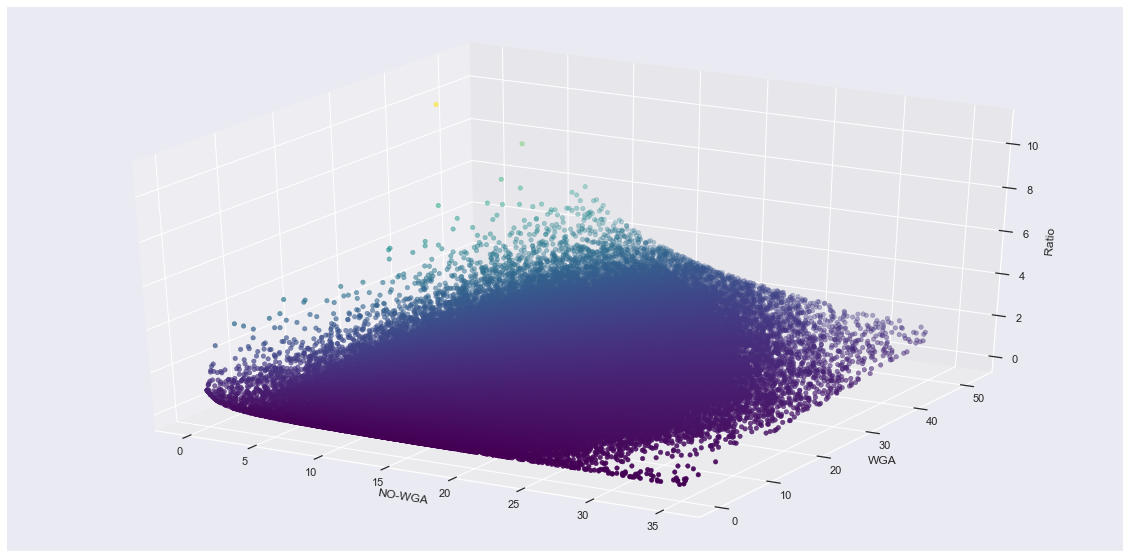

In [17]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(no_wga_mu, wga_mu, ratio, c=ratio, cmap='viridis', linewidth=0.5);
ax.set_xlabel('NO-WGA')
ax.set_ylabel('WGA')
ax.set_zlabel('Ratio')

In [18]:
print("GC size {0}".format(len(gc)))
print("GC max: {0}".format(max(gc)))
print("GC min: {0}".format(min(gc)))
print("GC mean: {0}".format(np.mean(gc)))
print("GC var: {0}".format(np.var(gc)))

GC size 185329
GC max: 0.93
GC min: 0.0
GC mean: 0.49600305402824174
GC var: 0.01198275802638238


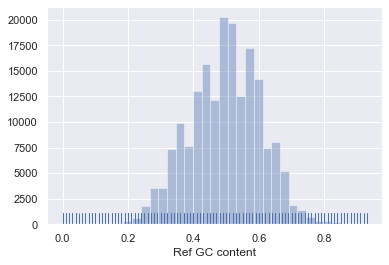

In [19]:
sns.distplot(gc, bins=35, kde=False, rug=True)
plt.xlabel("Ref GC content")
plt.show()

In [20]:
def make_data_array(wga_mu, no_wga_mu, gc, use_ratio, use_gc):
    data = []
    
    if use_ratio and use_gc:
        for no_wga_val, wga_val,gc_val in zip(no_wga_mu, wga_mu, gc):
            data.append([no_wga_val, wga_val, (wga_val + 1)/(no_wga_val + 1), gc_val])
    elif use_ratio:
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga,  (wga + 1)/(no_wga + 1)])
    elif use_gc:
        
        for no_wga_val, wga_val , gc_val in zip(no_wga_mu, wga_mu,  gc):
            data.append([no_wga_val, wga_val, gc_val])
    else:
        
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga ])
        
    return data

In [21]:
def kmeans_clustering(clusters, data, no_wga_mu, wga_mu):
    for nclusters in clusters:
    
        print("Number of clusters ", nclusters)
        kmeans = KMeans(n_clusters=nclusters)
        kmeans.fit(X=data)
        labels = kmeans.labels_
        centers = np.array(kmeans.cluster_centers_)

        calinski_harabasz_score = metrics.calinski_harabasz_score(data, labels)
        print("Calinski score: ", calinski_harabasz_score)
        davies_bouldin_score = metrics.davies_bouldin_score(data, labels)
        print("Davies score: ", davies_bouldin_score)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                          int(max(labels) + 1))))

        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])

        plt.scatter(no_wga_mu, wga_mu,  color=colors[labels])
        #plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        plt.show()
    

In [22]:
def gmm_clustering(clusters, data, cov_type, tol, max_itrs, n_init, no_wga_mu, wga_mu):
    
    for nclusters in clusters:
    
        print("Number of clusters ", nclusters)
        gmm = mixture.GaussianMixture(n_components=nclusters,
                                      covariance_type=cov_type,
                                      tol=tol, max_iter=max_itrs,
                                     n_init=n_init)
        gmm.fit(data)
        print("Converged: ", gmm.converged_)
        print("BIC: ", gmm.bic(data))
        labels = gmm.predict(data)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                          int(max(labels) + 1))))


        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])

        plt.scatter(no_wga_mu, wga_mu,  color=colors[labels])
        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        plt.show()
    

In [23]:
N_CLUSTERS = [2, 3, 4, 5]

## Two means 

In [24]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

### KMeans Clustering

Number of clusters  2
Calinski score:  218435.0776814247
Davies score:  0.7993186096998798


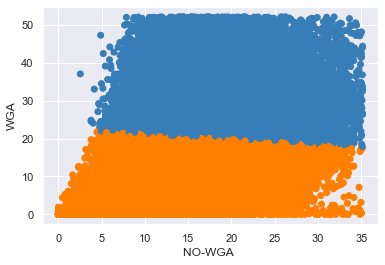

Number of clusters  3
Calinski score:  209573.82311887358
Davies score:  0.8706050284961605


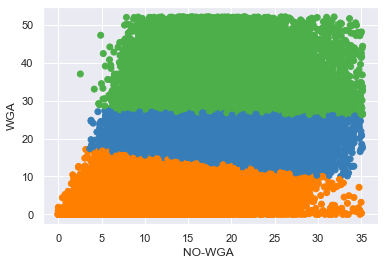

Number of clusters  4
Calinski score:  191999.59989362213
Davies score:  0.9466815015462189


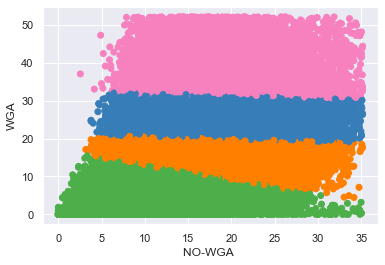

Number of clusters  5
Calinski score:  185147.12427107125
Davies score:  0.8982226052985489


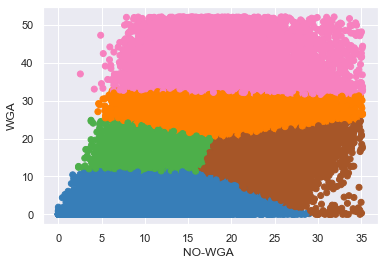

In [25]:
kmeans_clustering(clusters=N_CLUSTERS, data=data, no_wga_mu=no_wga_mu, wga_mu=wga_mu)


### GMM Clustering

### ```full```

Number of clusters  2
Converged:  True
BIC:  2440197.574860434


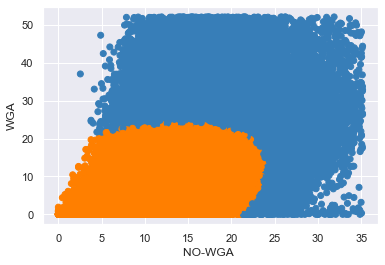

Number of clusters  3
Converged:  True
BIC:  2436163.2825072645


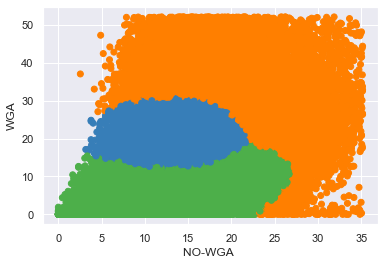

Number of clusters  4
Converged:  True
BIC:  2433671.188234922


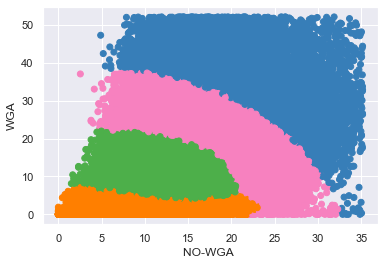

Number of clusters  5
Converged:  True
BIC:  2432199.706175836


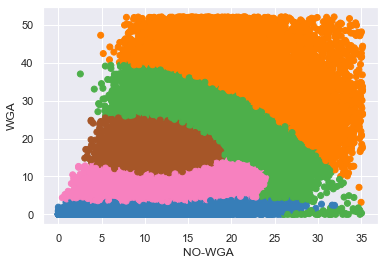

In [26]:
gmm_clustering(clusters=N_CLUSTERS, data=data, 
               tol=1.0e-5, max_itrs=300, n_init=1, 
               cov_type='full',
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)


### ```tied```

Number of clusters  2
Converged:  True
BIC:  2442664.8946395465


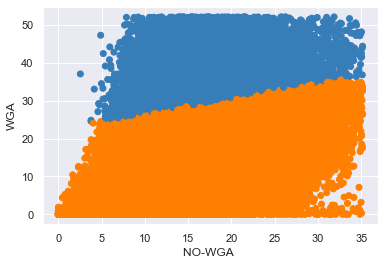

Number of clusters  3
Converged:  True
BIC:  2440315.704443699


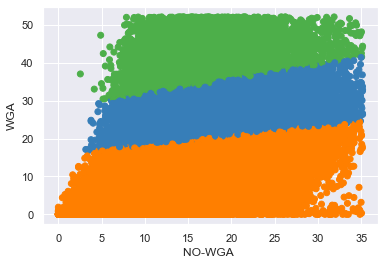

Number of clusters  4
Converged:  True
BIC:  2439171.5772138215


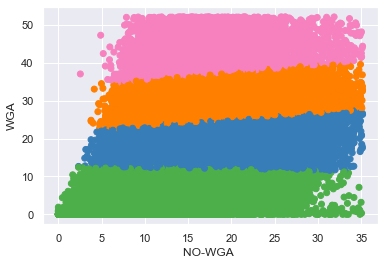

Number of clusters  5
Converged:  True
BIC:  2437646.522494721


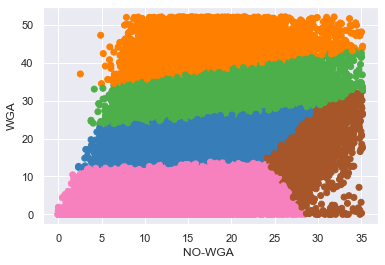

In [27]:
gmm_clustering(clusters=N_CLUSTERS, data=data, 
               tol=1.0e-5, cov_type='tied',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### ```diag```

Number of clusters  2
Converged:  True
BIC:  2445707.8588556275


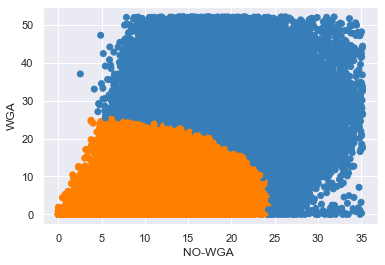

Number of clusters  3
Converged:  True
BIC:  2437317.7219388005


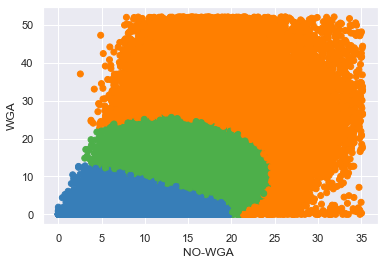

Number of clusters  4
Converged:  True
BIC:  2435136.096001128


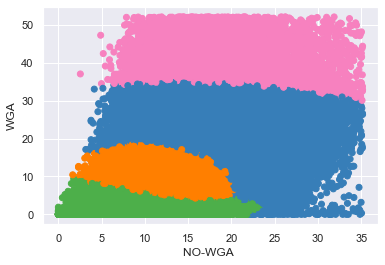

Number of clusters  5
Converged:  True
BIC:  2433081.69261612


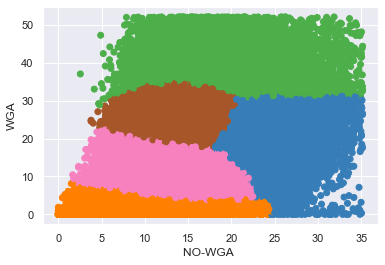

In [28]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, 
               cov_type='diag',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### ```spherical```

Number of clusters  2
Converged:  True
BIC:  2481078.047438065


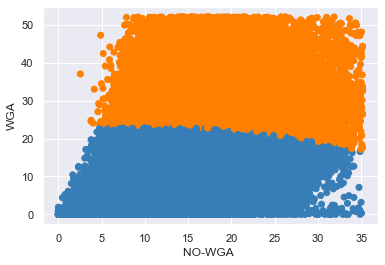

Number of clusters  3
Converged:  True
BIC:  2448803.373417471


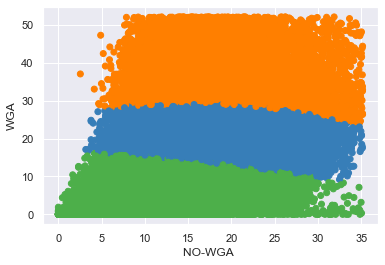

Number of clusters  4
Converged:  True
BIC:  2439622.9410172086


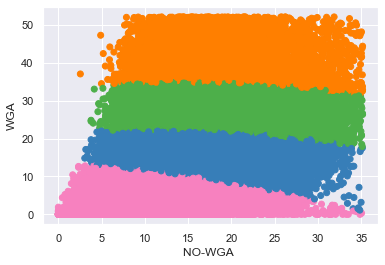

Number of clusters  5
Converged:  True
BIC:  2438212.8242986007


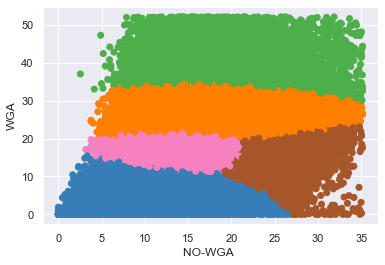

In [29]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, 
               cov_type='spherical',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

## Two means + Ratio

In [30]:

data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 3)

### KMeans

Number of clusters  2
Calinski score:  218085.1677332036
Davies score:  0.7996338022589593


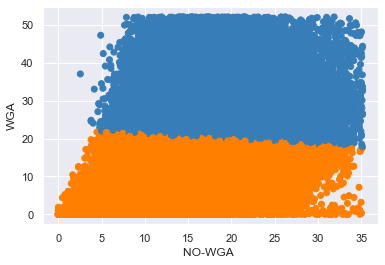

Number of clusters  3
Calinski score:  209087.49910629948
Davies score:  0.8705278287351952


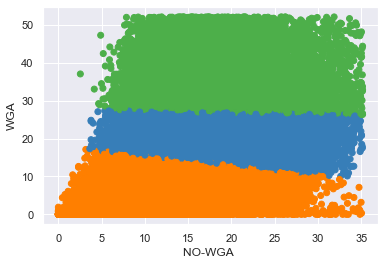

Number of clusters  4
Calinski score:  191404.7164629992
Davies score:  0.949863521010307


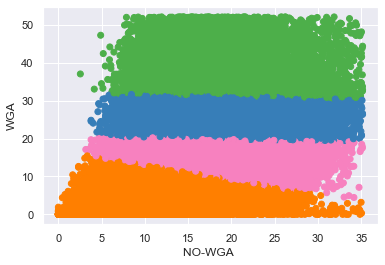

Number of clusters  5
Calinski score:  184575.2466344405
Davies score:  0.8996825737226389


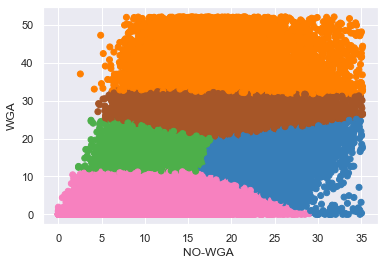

In [31]:
kmeans_clustering(clusters=N_CLUSTERS, data=data, no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### GMM

### ```full```

Number of clusters  2
Converged:  True
BIC:  2112135.786323783


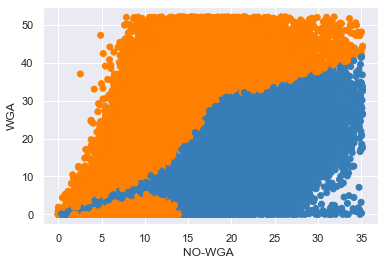

Number of clusters  3
Converged:  True
BIC:  1969278.7502214415


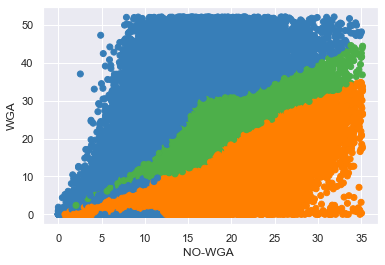

Number of clusters  4
Converged:  True
BIC:  1862295.08879422


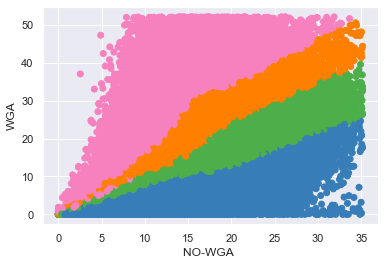

Number of clusters  5
Converged:  True
BIC:  1774424.9409197776


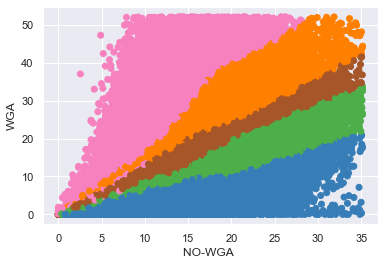

In [32]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='full',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### ```tied```

Number of clusters  2
Converged:  True
BIC:  2323747.5671049044


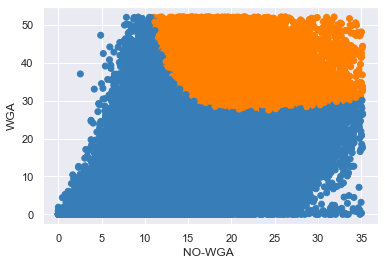

Number of clusters  3
Converged:  True
BIC:  2319508.650182907


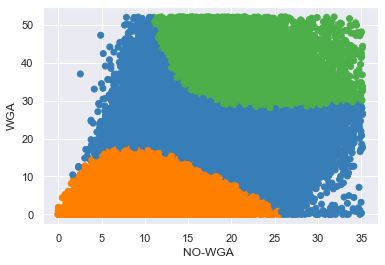

Number of clusters  4
Converged:  True
BIC:  2308238.532257942


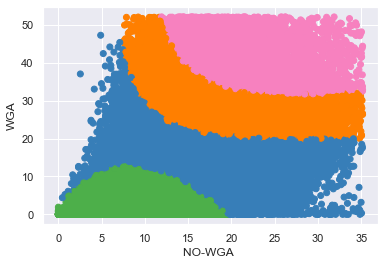

Number of clusters  5
Converged:  True
BIC:  2227547.048388627


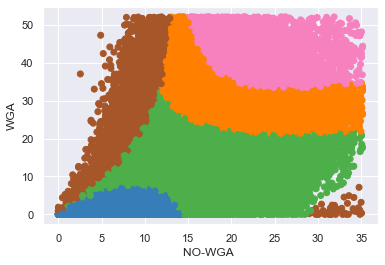

In [33]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-3, cov_type='tied',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### ```diag```

Number of clusters  2
Converged:  True
BIC:  2679163.006605453


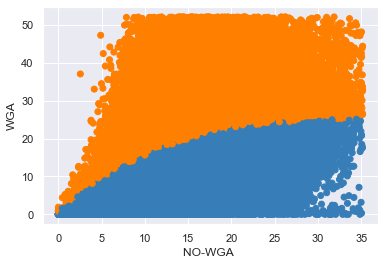

Number of clusters  3
Converged:  True
BIC:  2589260.4712051274


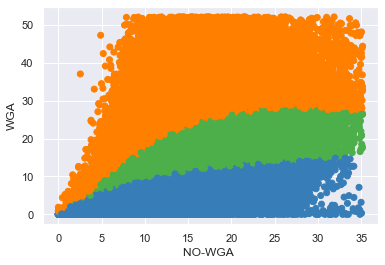

Number of clusters  4
Converged:  True
BIC:  2536688.4138924074


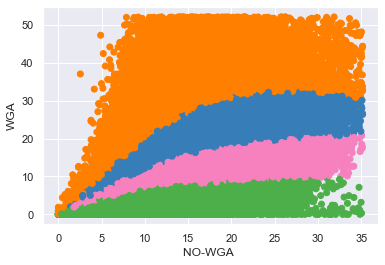

Number of clusters  5
Converged:  True
BIC:  2505874.6762590613


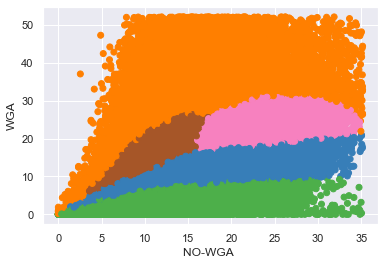

In [34]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, 
               cov_type='diag',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### ```spherical```

Number of clusters  2
Converged:  True
BIC:  3411639.6074676043


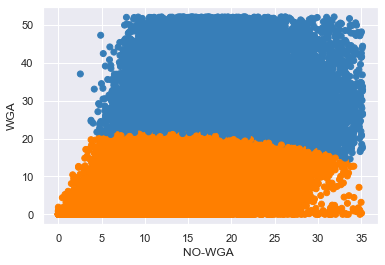

Number of clusters  3
Converged:  True
BIC:  3310746.654391032


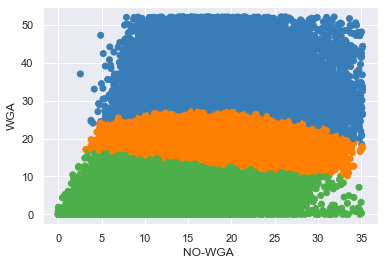

Number of clusters  4
Converged:  True
BIC:  3270420.793840775


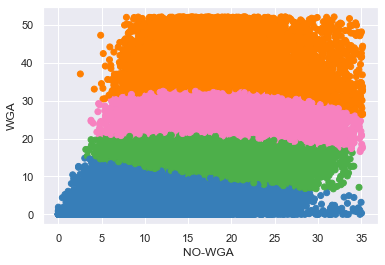

Number of clusters  5
Converged:  True
BIC:  3230760.759192131


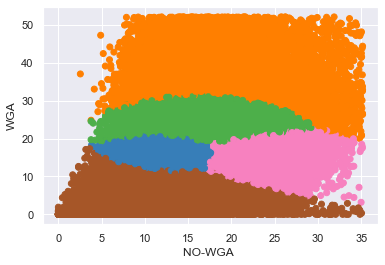

In [35]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, 
               cov_type='spherical', 
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

## TUF Region Refined I

- Region: [19001200-19126800]
- Window size: 100
- Sam configuration



In [36]:
wga_mean_file = "/home/a/ag568/wga_windows_mean_0_TUF_DETAIL_I.txt"
no_wga_mean_file = "/home/a/ag568/no_wga_windows_mean_0_TUF_DETAIL_I.txt"
gc_file = "/home/a/ag568/windows_gc_0_TUF_DETAIL_I.txt"

In [37]:
wga_mu = load_data_file(filename=wga_mean_file)
no_wga_mu = load_data_file(filename=no_wga_mean_file)
gc = load_data_file(filename=gc_file)

In [38]:
assert len(wga_mu) == len(no_wga_mu)
assert len(gc) == len(wga_mu)

In [39]:
print("Size of WGA sample {0}".format(len(wga_mu)))
print("WGA max: {0}".format(max(wga_mu)))
print("WGA min: {0}".format(min(wga_mu)))
print("WGA mean: {0}".format(np.mean(wga_mu)))
print("WGA var: {0}".format(np.var(wga_mu)))

Size of WGA sample 1231
WGA max: 39.87
WGA min: 0.0
WGA mean: 13.366961819658814
WGA var: 52.85683301153983


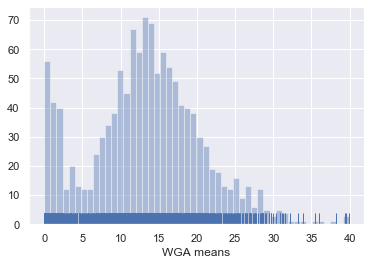

In [40]:
sns.distplot(wga_mu, bins=50, kde=False, rug=True)
plt.xlabel("WGA means")
plt.show()

In [41]:
print("NO-WGA size {0}".format(len(no_wga_mu)))
print("NO-WGA max: {0}".format(max(no_wga_mu)))
print("NO-WGA min: {0}".format(min(no_wga_mu)))
print("NO-WGA mean: {0}".format(np.mean(no_wga_mu)))
print("NO-WGA var: {0}".format(np.var(no_wga_mu)))

NO-WGA size 1231
NO-WGA max: 28.82
NO-WGA min: 0.38
NO-WGA mean: 16.412558895207148
NO-WGA var: 18.09481026765239


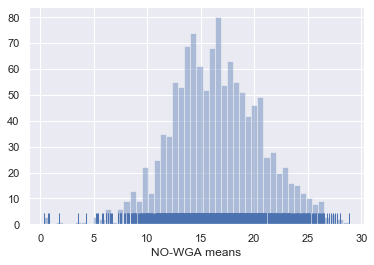

In [42]:
sns.distplot(no_wga_mu, bins=50, kde=False, rug=True)
plt.xlabel("NO-WGA means")
plt.show()

In [43]:
X = np.stack((no_wga_mu, wga_mu), axis=0)
cov = np.cov(X)
print("Covariance matrix: \n", cov)

v, w = linalg.eigh(cov)
print(" Eigenvalues: \n", v)
print(" Eigenvectors: \n", w)

Covariance matrix: 
 [[18.1095215  10.40633437]
 [10.40633437 52.89980605]]
 Eigenvalues: 
 [15.23442032 55.77490723]
 Eigenvectors: 
 [[-0.96388835  0.2663067 ]
 [ 0.2663067   0.96388835]]


In [44]:
ratio = []
for no_wga, wga  in zip(no_wga_mu, wga_mu):
    ratio.append((wga + 1)/(no_wga + 1))
    
ratio = np.array(ratio)
print("NaN in ratio: ", np.any(np.isnan(ratio)))
print("Max ratio: ", max(ratio))
print("Min ratio: ", min(ratio))
X = np.stack((no_wga_mu, wga_mu, ratio), axis=0)
cov = np.cov(X)
print("Covariance matrix: \n", cov)

v, w = linalg.eigh(cov)
print(" Eigenvalues: \n", v)
print(" Eigenvectors: \n", w)

NaN in ratio:  False
Max ratio:  2.9731127197518097
Min ratio:  0.052056220718375845
Covariance matrix: 
 [[18.1095215  10.40633437 -0.27978487]
 [10.40633437 52.89980605  2.6624147 ]
 [-0.27978487  2.6624147   0.18797244]]
 Eigenvalues: 
 [1.36939267e-02 1.52971786e+01 5.58864275e+01]
 Eigenvectors: 
 [[ 0.04992542  0.96295432 -0.26500268]
 [-0.06001255 -0.26196177 -0.96321053]
 [ 0.99694832 -0.06399217 -0.04471079]]


In [45]:
pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
print("Pearson correlation: ", pearson)

Pearson correlation:  0.336215126472358


In [46]:
print("GC size {0}".format(len(gc)))
print("GC max: {0}".format(max(gc)))
print("GC min: {0}".format(min(gc)))
print("GC mean: {0}".format(np.mean(gc)))
print("GC var: {0}".format(np.var(gc)))

GC size 1231
GC max: 0.72
GC min: 0.16
GC mean: 0.49246953696181966
GC var: 0.009178466781182832


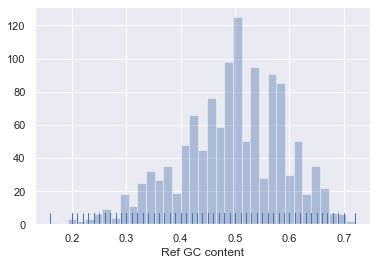

In [47]:
sns.distplot(gc, bins=35, kde=False, rug=True)
plt.xlabel("Ref GC content")
plt.show()

## Two Means

In [48]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

### KMeans Clustering

Number of clusters  2
Calinski score:  1123.1844788262563
Davies score:  0.9349666312953347


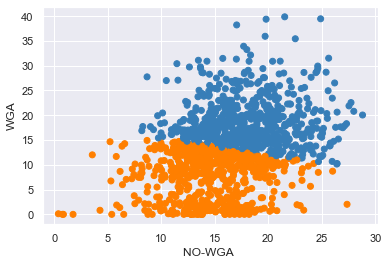

Number of clusters  3
Calinski score:  1135.6509393396357
Davies score:  0.9230801018758017


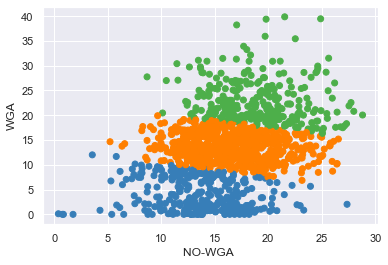

Number of clusters  4
Calinski score:  1108.712062338862
Davies score:  0.8898452621822635


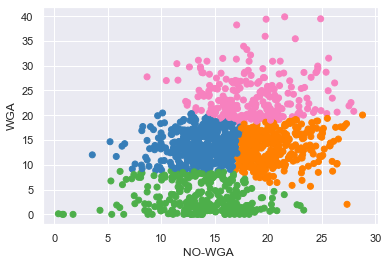

Number of clusters  5
Calinski score:  1060.5645044996108
Davies score:  0.8801661270253278


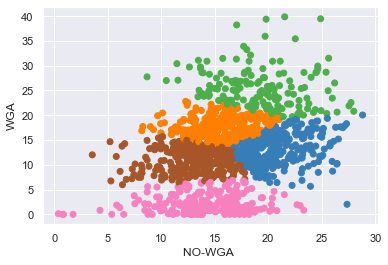

In [49]:
kmeans_clustering(clusters=N_CLUSTERS, data=data, no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### GMM Clustering

#### ```full```

Number of clusters  2
Converged:  True
BIC:  15344.001826045263


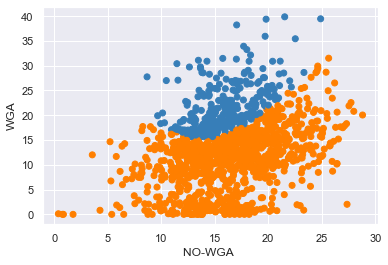

Number of clusters  3
Converged:  True
BIC:  15160.404943600122


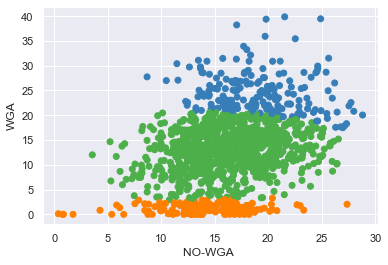

Number of clusters  4
Converged:  True
BIC:  15192.413388011848


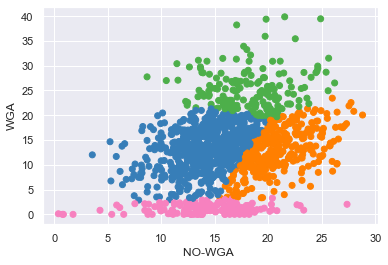

Number of clusters  5
Converged:  True
BIC:  15230.141614705593


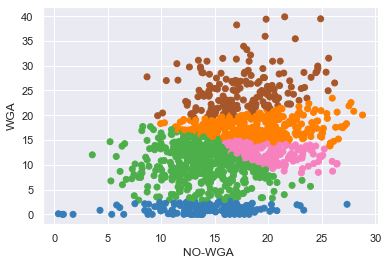

In [50]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='full',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

#### ```tied```

Number of clusters  2
Converged:  True
BIC:  15345.193376632076


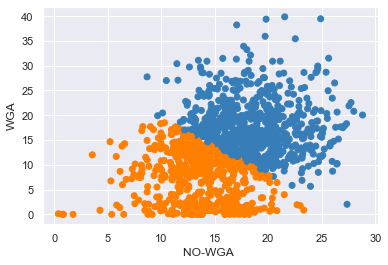

Number of clusters  3
Converged:  True
BIC:  15290.339353386102


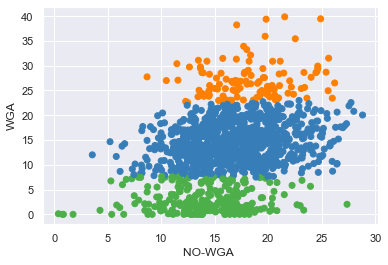

Number of clusters  4
Converged:  True
BIC:  15278.727341309834


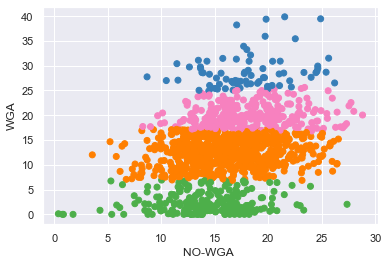

Number of clusters  5
Converged:  True
BIC:  15299.51148568629


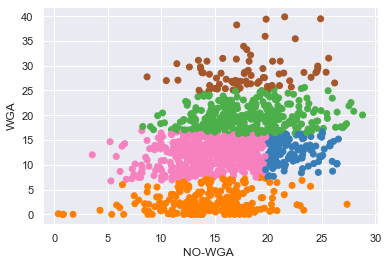

In [51]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, 
               cov_type='tied', max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

#### ```diag```

Number of clusters  2
Converged:  True
BIC:  15366.00942291375


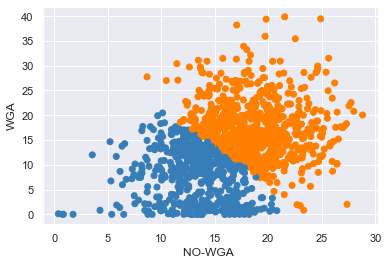

Number of clusters  3
Converged:  True
BIC:  15166.826775028667


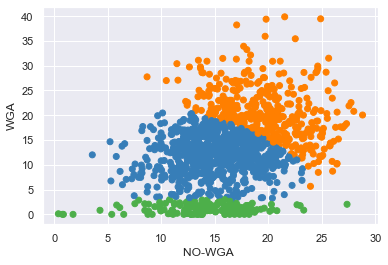

Number of clusters  4
Converged:  True
BIC:  15175.33072825678


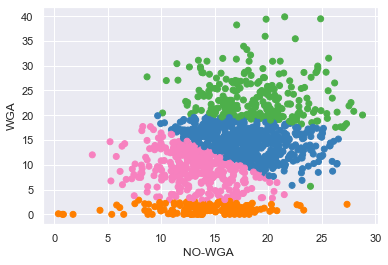

Number of clusters  5
Converged:  True
BIC:  15201.039841916201


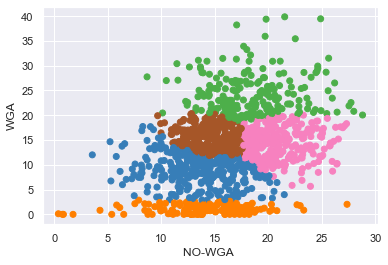

In [52]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='diag',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

#### ```spherical```

Number of clusters  2
Converged:  True
BIC:  15495.640797386402


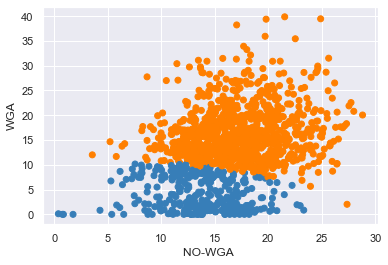

Number of clusters  3
Converged:  True
BIC:  15297.070879034762


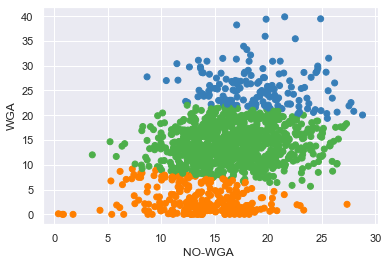

Number of clusters  4
Converged:  True
BIC:  15302.696641073855


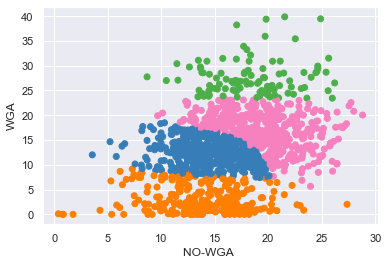

Number of clusters  5
Converged:  True
BIC:  15319.667290318188


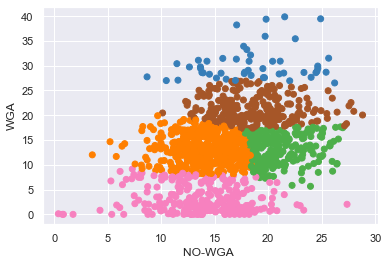

In [53]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='spherical',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

## Two means + Ratio

In [54]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 3)

### KMeans

Number of clusters  2
Calinski score:  1121.1890937609107
Davies score:  0.9357525126959545


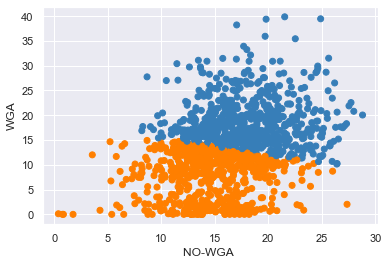

Number of clusters  3
Calinski score:  1133.3112244227307
Davies score:  0.9224761033026994


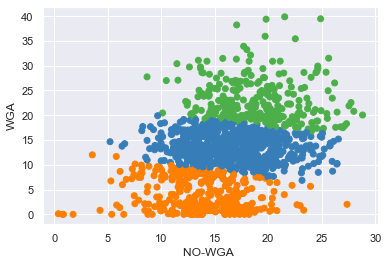

Number of clusters  4
Calinski score:  1107.22639700305
Davies score:  0.8898665731451626


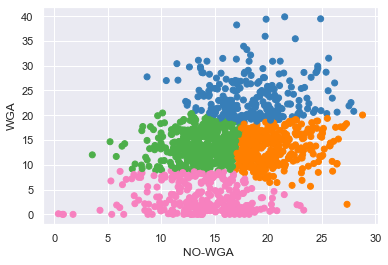

Number of clusters  5
Calinski score:  1059.1210956686878
Davies score:  0.8802572819341734


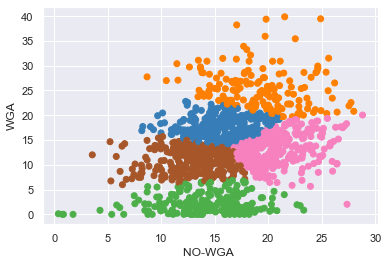

In [55]:
kmeans_clustering(clusters=N_CLUSTERS, data=data, no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### GMM

#### ```full```

Number of clusters  2
Converged:  True
BIC:  12354.098412607236


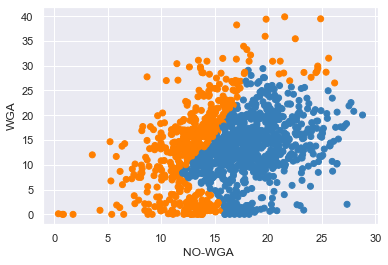

Number of clusters  3
Converged:  True
BIC:  11430.914226646511


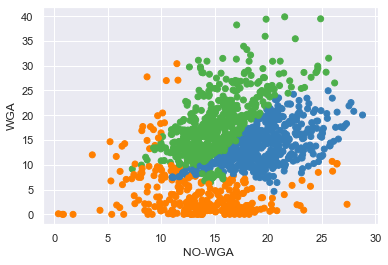

Number of clusters  4
Converged:  True
BIC:  10336.684818217338


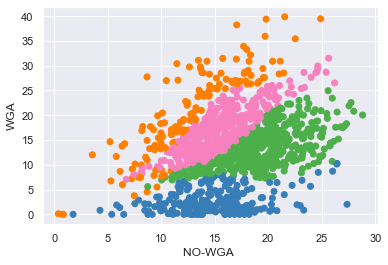

Number of clusters  5
Converged:  True
BIC:  9695.83055989834


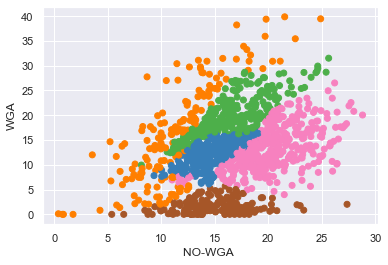

In [56]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='full',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

#### ```tied```

Number of clusters  2
Converged:  True
BIC:  13602.614816157104


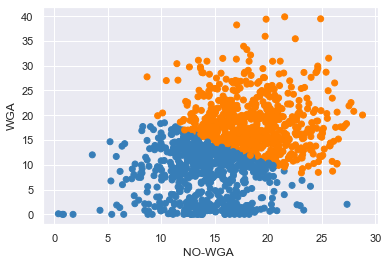

Number of clusters  3
Converged:  True
BIC:  13415.411680236497


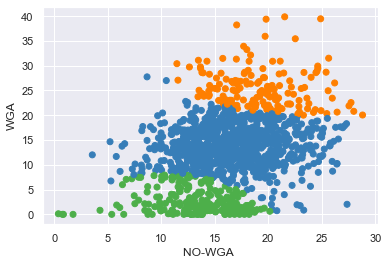

Number of clusters  4
Converged:  True
BIC:  13214.277758863147


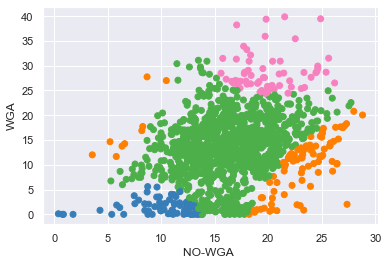

Number of clusters  5
Converged:  True
BIC:  12826.604343494282


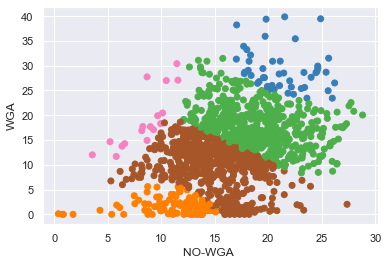

In [57]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-3, cov_type='tied',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

#### ```diag```

Number of clusters  2
Converged:  True
BIC:  15936.251347590829


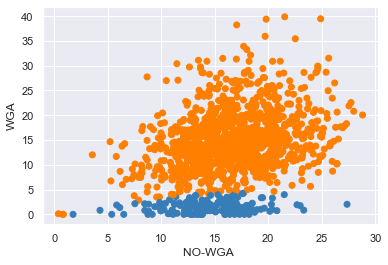

Number of clusters  3
Converged:  True
BIC:  15265.067443327074


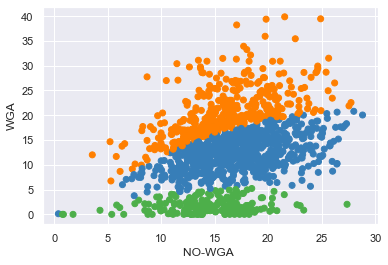

Number of clusters  4
Converged:  True
BIC:  14972.237731384199


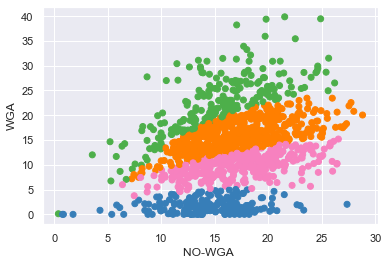

Number of clusters  5
Converged:  True
BIC:  14772.48400699233


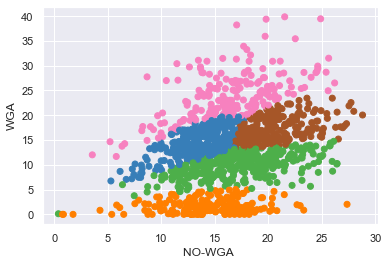

In [58]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='diag',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

#### ```spherical```

Number of clusters  2
Converged:  True
BIC:  21226.01337393271


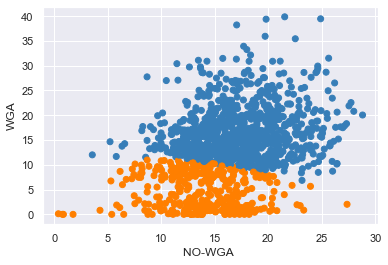

Number of clusters  3
Converged:  True
BIC:  20578.17850213878


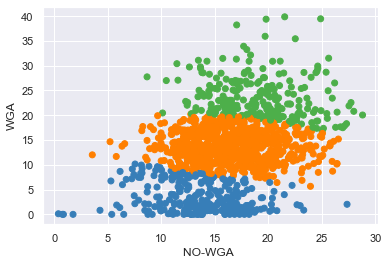

Number of clusters  4
Converged:  True
BIC:  20285.949245695632


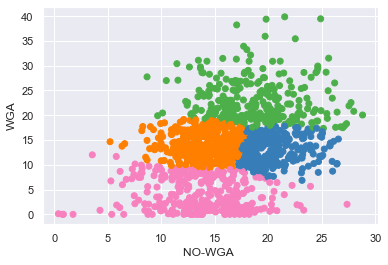

Number of clusters  5
Converged:  True
BIC:  20093.165791259777


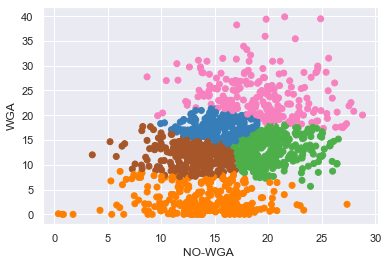

In [59]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='spherical',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

## TUF Region Refined II

- Region: [5488300-6492700]
- Window size: 100
- Chromosome: chr1

In [84]:
wga_mean_file = "/home/a/ag568/wga_windows_mean_0_TUF_DETAIL_II.txt"
no_wga_mean_file = "/home/a/ag568/no_wga_windows_mean_0_TUF_DETAIL_II.txt"
gc_file = "/home/a/ag568/windows_gc_0_TUF_DETAIL_II.txt"

In [85]:
wga_mu = load_data_file(filename=wga_mean_file)
no_wga_mu = load_data_file(filename=no_wga_mean_file)
gc = load_data_file(filename=gc_file)

In [86]:
assert len(wga_mu) == len(no_wga_mu)
assert len(gc) == len(wga_mu)

In [87]:


print("Size of WGA sample {0}".format(len(wga_mu)))
print("WGA max: {0}".format(max(wga_mu)))
print("WGA min: {0}".format(min(wga_mu)))
print("WGA mean: {0}".format(np.mean(wga_mu)))
print("WGA var: {0}".format(np.var(wga_mu)))



Size of WGA sample 9856
WGA max: 50.64
WGA min: 0.0
WGA mean: 16.028602881493505
WGA var: 87.74611208012158


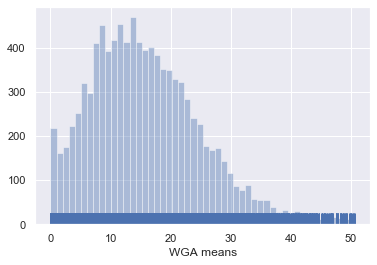

In [88]:
sns.distplot(wga_mu, bins=50, kde=False, rug=True)
plt.xlabel("WGA means")
plt.show()

In [89]:
print("NO-WGA size {0}".format(len(no_wga_mu)))
print("NO-WGA max: {0}".format(max(no_wga_mu)))
print("NO-WGA min: {0}".format(min(no_wga_mu)))
print("NO-WGA mean: {0}".format(np.mean(no_wga_mu)))
print("NO-WGA var: {0}".format(np.var(no_wga_mu)))

NO-WGA size 9856
NO-WGA max: 30.13
NO-WGA min: 0.05
NO-WGA mean: 15.55252637987013
NO-WGA var: 18.3086353990606


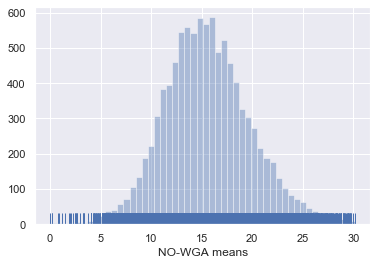

In [90]:
sns.distplot(no_wga_mu, bins=50, kde=False, rug=True)
plt.xlabel("NO-WGA means")
plt.show()

In [91]:
X = np.stack((no_wga_mu, wga_mu), axis=0)
cov = np.cov(X)
print("Covariance matrix: \n", cov)

v, w = linalg.eigh(cov)
print(" Eigenvalues: \n", v)
print(" Eigenvectors: \n", w)

Covariance matrix: 
 [[18.3104932   8.17360434]
 [ 8.17360434 87.7550158 ]]
 Eigenvalues: 
 [17.36143216 88.70407684]
 Eigenvectors: 
 [[-0.9933263   0.11533801]
 [ 0.11533801  0.9933263 ]]


In [92]:


ratio = []
for no_wga, wga  in zip(no_wga_mu, wga_mu):
    ratio.append((wga + 1)/(no_wga + 1))
    
ratio = np.array(ratio)
print("NaN in ratio: ", np.any(np.isnan(ratio)))
print("Max ratio: ", max(ratio))
print("Min ratio: ", min(ratio))
X = np.stack((no_wga_mu, wga_mu, ratio), axis=0)
cov = np.cov(X)
print("Covariance matrix: \n", cov)

v, w = linalg.eigh(cov)
print(" Eigenvalues: \n", v)
print(" Eigenvectors: \n", w)



NaN in ratio:  False
Max ratio:  6.049204052098408
Min ratio:  0.044762757385854966
Covariance matrix: 
 [[18.3104932   8.17360434 -0.74114202]
 [ 8.17360434 87.7550158   5.04142535]
 [-0.74114202  5.04142535  0.4094637 ]]
 Eigenvalues: 
 [3.59951744e-02 1.74612625e+01 8.89777150e+01]
 Eigenvectors: 
 [[ 0.06883882  0.99107617 -0.11414571]
 [-0.0636337  -0.10982209 -0.99191222]
 [ 0.99559629 -0.07554558 -0.05550582]]


In [93]:


pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
print("Pearson correlation: ", pearson)



Pearson correlation:  0.20390487801405047


In [94]:
print("GC size {0}".format(len(gc)))
print("GC max: {0}".format(max(gc)))
print("GC min: {0}".format(min(gc)))
print("GC mean: {0}".format(np.mean(gc)))
print("GC var: {0}".format(np.var(gc)))

GC size 9856
GC max: 0.88
GC min: 0.14
GC mean: 0.5247991071428572
GC var: 0.011584740486215793


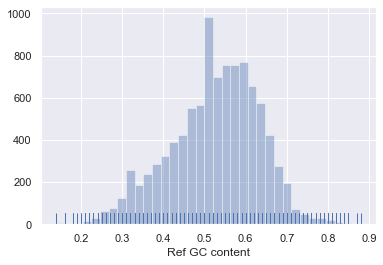

In [95]:
sns.distplot(gc, bins=35, kde=False, rug=True)
plt.xlabel("Ref GC content")
plt.show()

## Two Means

In [96]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

### KMeans Clustering

Number of clusters  2
Calinski score:  11581.4794848834
Davies score:  0.8005982105690991


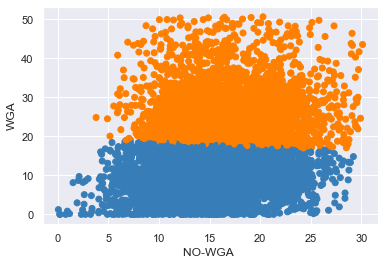

Number of clusters  3
Calinski score:  10731.54301771149
Davies score:  0.8714659673065109


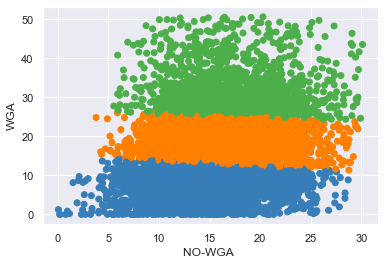

Number of clusters  4
Calinski score:  9733.519629295903
Davies score:  0.95454221155651


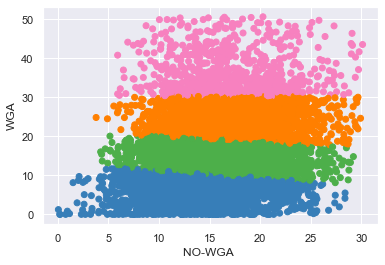

Number of clusters  5
Calinski score:  9389.46107031859
Davies score:  0.9091226741834623


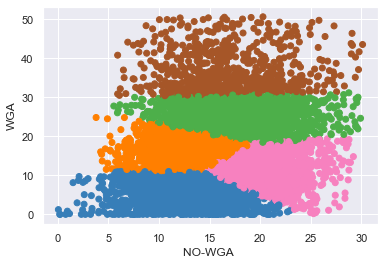

In [97]:
kmeans_clustering(clusters=N_CLUSTERS, data=data, no_wga_mu=no_wga_mu, wga_mu=wga_mu)

### GMM Clustering

#### ```full```

Number of clusters  2
Converged:  True
BIC:  127430.6586244891


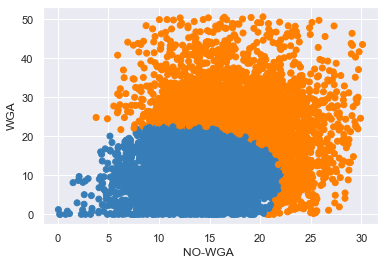

Number of clusters  3
Converged:  True
BIC:  127167.1574395475


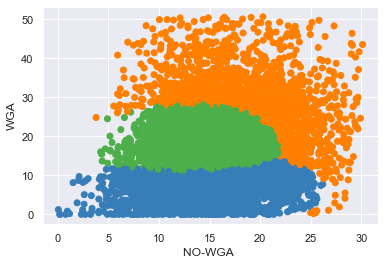

Number of clusters  4
Converged:  True
BIC:  127166.99659170528


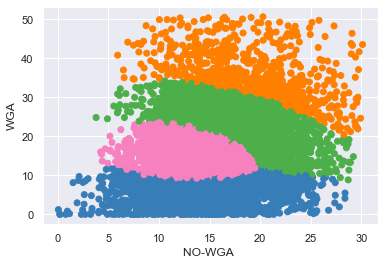

Number of clusters  5


/home/a/ag568/miniconda3/envs/pconda_env/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Converged:  False
BIC:  127034.71377726614


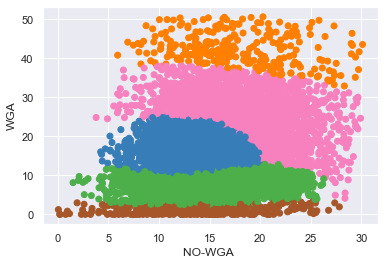

In [98]:


gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='full',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)



#### ```tied```

Number of clusters  2
Converged:  True
BIC:  127609.14264984558


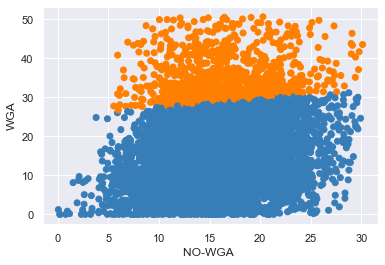

Number of clusters  3
Converged:  True
BIC:  127344.63613721827


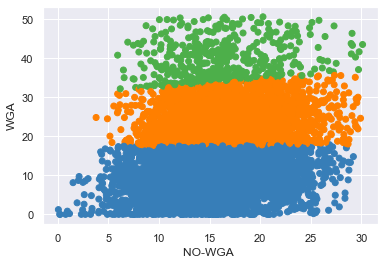

Number of clusters  4
Converged:  True
BIC:  127275.00130426444


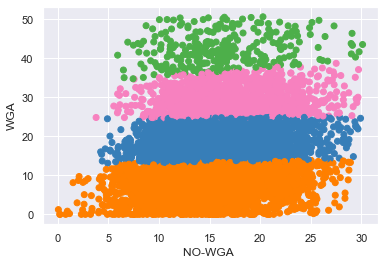

Number of clusters  5
Converged:  True
BIC:  127302.6702205992


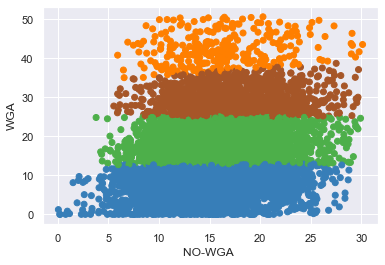

In [100]:


gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, 
               cov_type='tied', max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)



#### ```diag```

Number of clusters  2
Converged:  True
BIC:  127504.16825968107


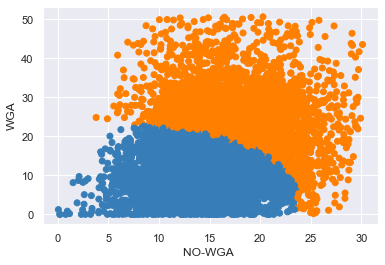

Number of clusters  3
Converged:  True
BIC:  127205.4175511024


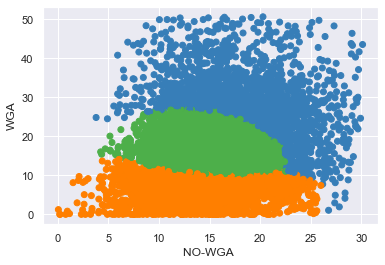

Number of clusters  4
Converged:  True
BIC:  127157.05468681856


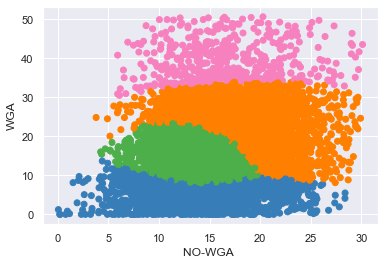

Number of clusters  5
Converged:  True
BIC:  127159.95033635823


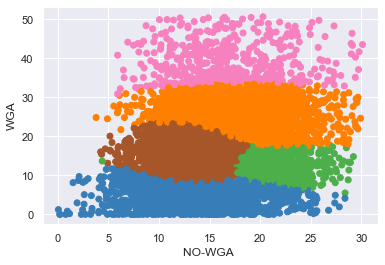

In [101]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='diag',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

#### ```spherical```

Number of clusters  2
Converged:  True
BIC:  129362.52320624965


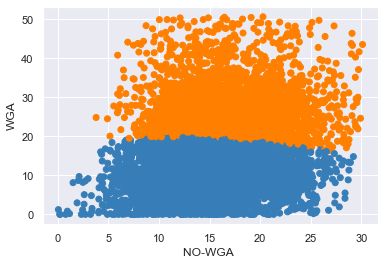

Number of clusters  3
Converged:  True
BIC:  127620.76206965599


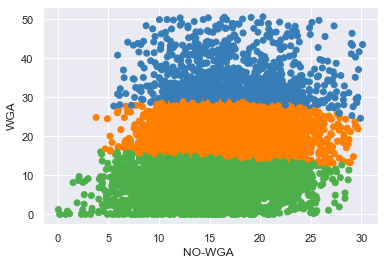

Number of clusters  4
Converged:  True
BIC:  127274.08599710901


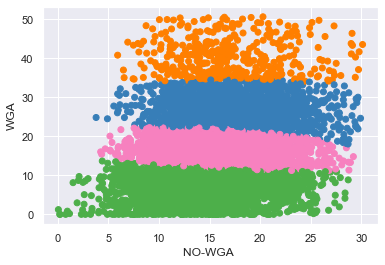

Number of clusters  5
Converged:  True
BIC:  127250.95563114206


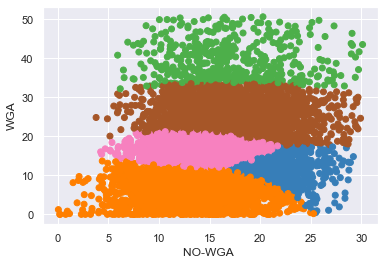

In [102]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='spherical',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

## Two means + Ratio

In [103]:


data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 3)



### KMeans

Number of clusters  2
Calinski score:  11558.999754851257
Davies score:  0.8009138918898395


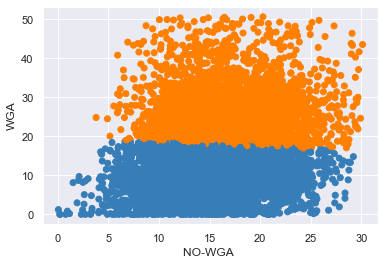

Number of clusters  3
Calinski score:  10704.061972414163
Davies score:  0.8728587037188499


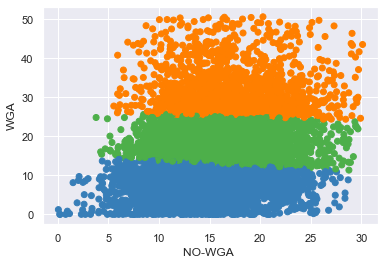

Number of clusters  4
Calinski score:  9703.46655123043
Davies score:  0.9584707586677601


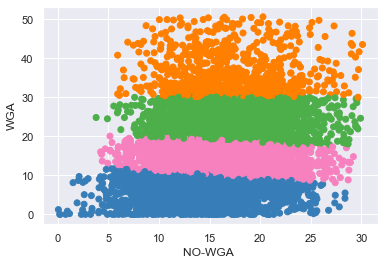

Number of clusters  5
Calinski score:  9356.746300051554
Davies score:  0.909944170427492


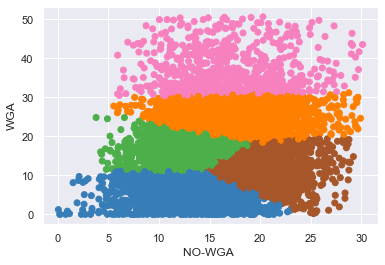

In [104]:
kmeans_clustering(clusters=N_CLUSTERS, data=data, no_wga_mu=no_wga_mu, wga_mu=wga_mu)

###  GMM

#### ```full```

Number of clusters  2
Converged:  True
BIC:  110054.82544668541


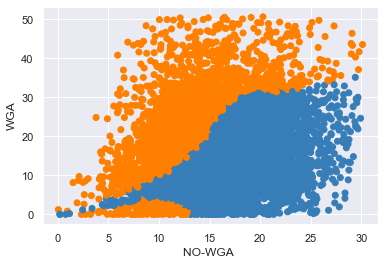

Number of clusters  3
Converged:  True
BIC:  101703.11022671801


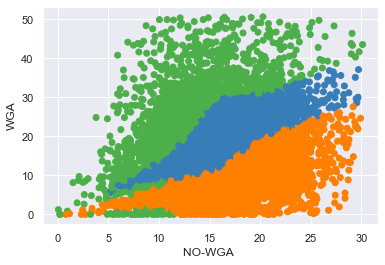

Number of clusters  4
Converged:  True
BIC:  95903.65868765739


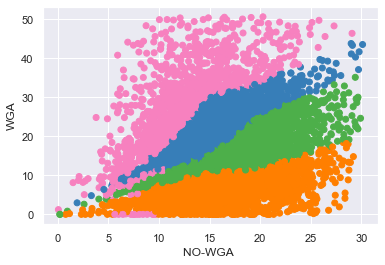

Number of clusters  5
Converged:  True
BIC:  91943.40045632089


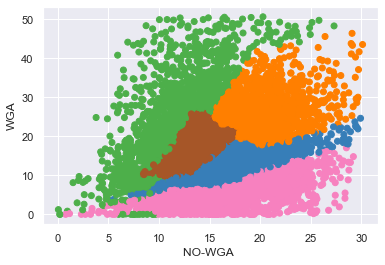

In [105]:


gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='full',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)



#### ```tied```

Number of clusters  2
Converged:  True
BIC:  122664.30828710002


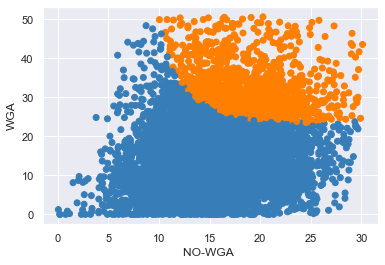

Number of clusters  3
Converged:  True
BIC:  122476.22712821132


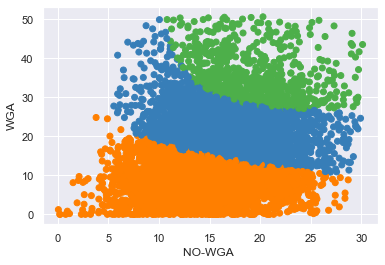

Number of clusters  4
Converged:  True
BIC:  122067.70193346025


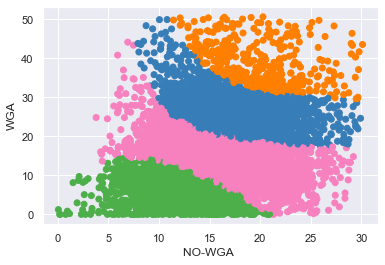

Number of clusters  5
Converged:  True
BIC:  117155.67798441887


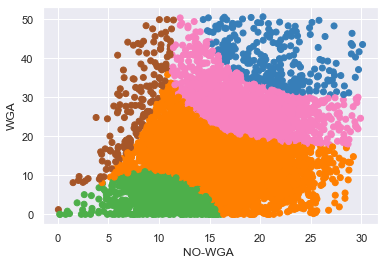

In [106]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-3, cov_type='tied',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)

#### ```diag```

Number of clusters  2
Converged:  True
BIC:  139826.98685432374


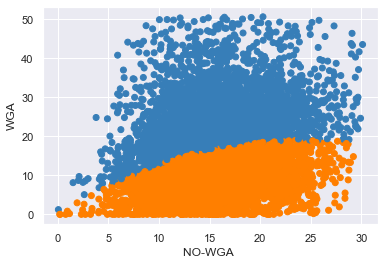

Number of clusters  3
Converged:  True
BIC:  134655.34970669934


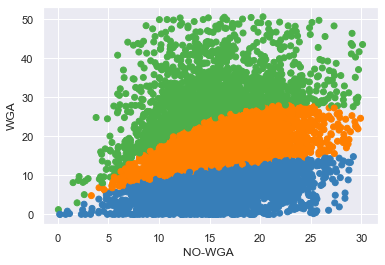

Number of clusters  4
Converged:  True
BIC:  131377.7054172256


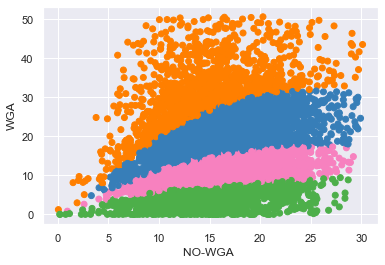

Number of clusters  5
Converged:  True
BIC:  129575.33172734731


In [ ]:


gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='diag',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)



#### ```spherical```

Number of clusters  2
Converged:  True
BIC:  177442.20070202262


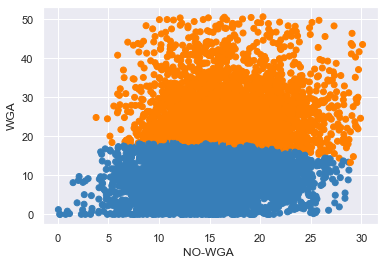

Number of clusters  3
Converged:  True
BIC:  172332.80775731086


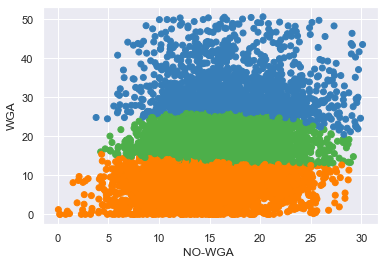

Number of clusters  4
Converged:  True
BIC:  170496.2749339392


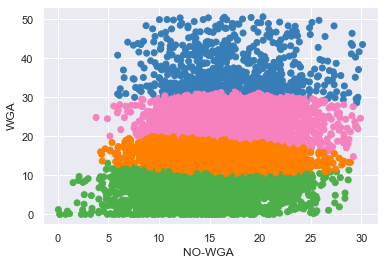

Number of clusters  5
Converged:  True
BIC:  168521.64252218165


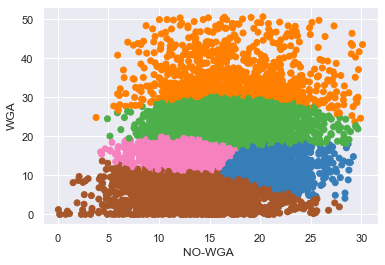

In [83]:
gmm_clustering(clusters=N_CLUSTERS, data=data, tol=1.0e-5, cov_type='spherical',
               max_itrs=300, n_init=1,
               no_wga_mu=no_wga_mu, wga_mu=wga_mu)